In [1]:
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets

In [2]:
input_shape=(28,28,1)
num_classes = 10

In [3]:
inputs = layers.Input(input_shape, dtype=tf.float64)
net = layers.Conv2D(32,(3,3), padding = 'SAME')(inputs)
net = layers.Activation('relu')(net)
net = layers.Conv2D(32,(3,3), padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2,2))(net)
net = layers.Dropout(0.5)(net)

net = layers.Conv2D(64,(3,3), padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.Conv2D(64,(3,3), padding = 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size=(2,2))(net)
net = layers.Dropout(0.5)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(0.5)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs=inputs, outputs = net, name='Basic_CNN')


### Preprocess
텐서플로우 공식 홈페이지에서 말한 expert한 방법
- tf.data 사용

In [4]:
mnist = tf.keras.datasets.mnist

#Load Data from MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#Chnnel 차원 추가
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

#Data Normalization
x_train, x_test = x_train / 255.0, x_test / 255.0

- from_tensor_slices()
- shuffle()
- batch()

### tf.data

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test))
test_ds = test_ds.batch(32)

### Visualize Data
matplotlib 불러와서 데이터 시각화하기

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

train_ds.take()

In [8]:
image, label = next(iter(train_ds))

In [9]:
image.shape, label.shape

(TensorShape([32, 28, 28, 1]), TensorShape([32]))

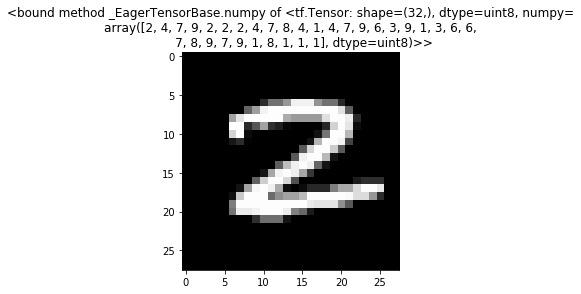

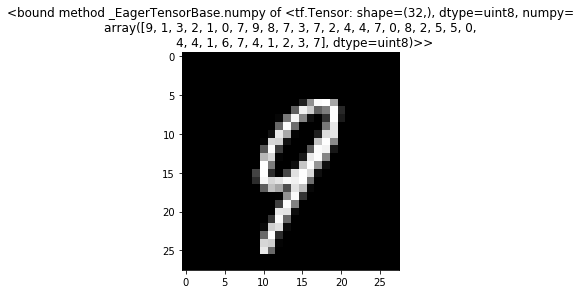

In [10]:
for image, label in train_ds.take(2):
    plt.title(label.numpy)
    plt.imshow(image[0,:,:,0],'gray')
    plt.show()

### Training(Keras)
Keras로 학습 할 때는 기존과 같지만, train_ds는 generator라서 그대로 넣을 수 있음

In [11]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.fit(train_ds, epochs=1)

1875/1875 [==============================] - 137s 72ms/step - loss: 0.1964


### Optimization
- Loss Function
- Optimizer

In [12]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

- Loss Function를 담을 곳
- Metrics

In [13]:
#loss값을 평균내 줄 함수
train_loss = tf.keras.metrics.Mean(name='train_loss')
#평가 할 함수
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='trian_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

### Training
@tf.function - 기존 session 열었던 것처럼 바로 작동 안 하고, 그래프만 만들고 학습이 시작되면 돌아가도록 함

In [14]:
@tf.function #속도가 빨라짐
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

In [15]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [17]:
for epoch in range(2):
    for image, labels in train_ds:
        train_step(image, labels)
    
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
        
    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss{}, Test Accuracy{}'
    
    print(template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result() *100,
                         test_loss.result(),
                         test_accuracy.result() * 100))

Epoch 1, Loss: 0.04657512903213501, Accuracy: 98.57666778564453, Test Loss0.02994212508201599, Test Accuracy99.16999816894531
Epoch 2, Loss: 0.036524660885334015, Accuracy: 98.88500213623047, Test Loss0.03343331441283226, Test Accuracy99.0
